In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
%matplotlib inline
import numbers
import ctypes
import _pickle as cPickle
import pydicom as dicom

import cv2
import os
import time
import PIL
import re
import math
import sys
#import pylab

import SimpleITK as sitk
from PIL import Image
from scipy import linalg

print ('OpenCV version = ' + cv2.__version__)
print("Using PyTorch Version %s" %torch.__version__)

OpenCV version = 3.4.2
Using PyTorch Version 1.3.1


In [3]:
dataDir = "/user/iibi/skuanar/Downloads/featExtract1.6/featExtract1.6/ShibaNew/H-18151/"
image = sitk.ReadImage ( dataDir + "H-18151_V2_INSP.nii" )

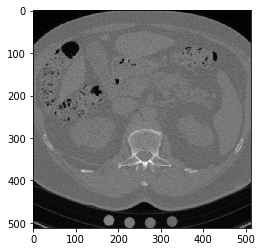

In [4]:
z = 0
slice = sitk.GetArrayFromImage(image)[z,:,:]
plt.imshow(slice, cmap='gray')

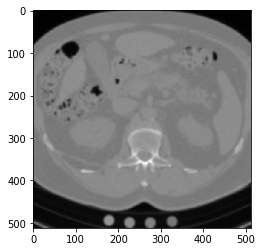

In [4]:
# Simple smoothing
smooth = sitk.SmoothingRecursiveGaussian (image, 2.0 )
z = 0
slice = sitk.GetArrayFromImage(smooth)[z,:,:]
plt.imshow(slice, cmap='gray')

# A different smoothing filter

In [5]:
# https://simpleitk.github.io/SPIE2019_COURSE/05_advanced_registration.html
def smooth_and_resample(image, shrink_factor, smoothing_sigma):
    """
    Args:
        image: The image we want to resample.
        shrink_factor: A number greater than one, such that the new image's size is original_size/shrink_factor.
        smoothing_sigma: Sigma for Gaussian smoothing, this is in physical (image spacing) units, not pixels.
    Return:
        Image which is a result of smoothing the input and then resampling it using the given sigma and shrink factor.
    """
    smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigma)
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [int(sz/float(shrink_factor) + 0.5) for sz in original_size]
    new_spacing = [((original_sz-1)*original_spc)/(new_sz-1) 
                   for original_sz, original_spc, new_sz in zip(original_size, original_spacing, new_size)]
    return sitk.Resample(smoothed_image, new_size, sitk.Transform(), sitk.sitkLinear, image.GetOrigin(),
                         new_spacing, image.GetDirection(), 0.0, image.GetPixelID())

In [6]:
other_smooth = smooth_and_resample(image, shrink_factor=2, smoothing_sigma= 2)

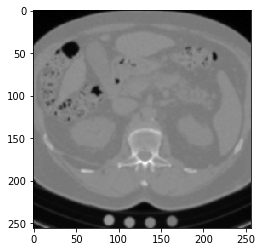

In [7]:
z = 0
slice = sitk.GetArrayFromImage(other_smooth)[z,:,:]
plt.imshow(slice, cmap='gray')

# Show the difference between the original and smoothed

Before:  32-bit float
After:  32-bit float


Text(0.5, 1.0, 'DiffWithGaussian')

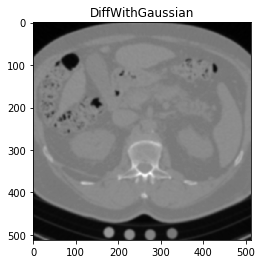

In [8]:
#img2 = sitk.Cast(smooth, sitk.sitkInt16)  # cast from "smooth" 32-bit float - to "sitk.sitkInt16" (16-bit signed integer)

# Much better
print ("Before: ", smooth.GetPixelIDTypeAsString())
img2 = sitk.Cast (smooth, image.GetPixelIDValue())

print ("After: ", smooth.GetPixelIDTypeAsString())
#sitk.Show ( sitk.Subtract ( image, smooth ), "DiffWithGaussian" )

diff_image = sitk.Subtract(image, img2)
z = 0
slice = sitk.GetArrayFromImage(img2)[z,:,:]
plt.imshow(slice, cmap='gray')
plt.title("DiffWithGaussian")

In [9]:
image.GetSize()

(512, 512, 647)

In [10]:
smooth.GetSize()

(512, 512, 647)

In [11]:
print (image.GetPixelIDTypeAsString())

16-bit signed integer


In [12]:
print (smooth.GetPixelIDTypeAsString())

32-bit float


# Flip

Text(0.5, 1.0, 'Flipped Image')

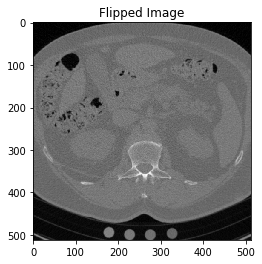

In [13]:
flip_image = sitk.Flip (image)
z = 0
slice_flip = sitk.GetArrayFromImage(flip_image)[z,:,:]
plt.imshow(slice_flip, cmap='gray')
plt.title("Flipped Image")

# Rotation of CT Images

In [14]:
# This function is from https://github.com/rock-learning/pytransform3d/blob/7589e083a50597a75b12d745ebacaa7cc056cfbd/pytransform3d/rotations.py#L302
# https://stackoverflow.com/questions/56171643/simpleitk-rotation-of-mri-image/56175527

def matrix_from_axis_angle(a):
    """ Compute rotation matrix from axis-angle.
    This is called exponential map or Rodrigues' formula.
    Parameters
    ----------
    a : array-like, shape (4,)
        Axis of rotation and rotation angle: (x, y, z, angle)
    Returns
    -------
    R : array-like, shape (3, 3)
        Rotation matrix
    """
    ux, uy, uz, theta = a
    c = np.cos(theta)
    s = np.sin(theta)
    ci = 1.0 - c
    R = np.array([[ci * ux * ux + c, ci * ux * uy - uz * s, ci * ux * uz + uy * s],
                  [ci * uy * ux + uz * s, ci * uy * uy + c, ci * uy * uz - ux * s],
                  [ci * uz * ux - uy * s, ci * uz * uy + ux * s, ci * uz * uz + c],
                ])

    # This is equivalent to
    # R = (np.eye(3) * np.cos(theta) +
    #      (1.0 - np.cos(theta)) * a[:3, np.newaxis].dot(a[np.newaxis, :3]) +
    #      cross_product_matrix(a[:3]) * np.sin(theta))

    return R


def resample(image, transform):
    """
    This function resamples (updates) an image using a specified transform
    :param image: The sitk image we are trying to transform
    :param transform: An sitk transform (ex. resizing, rotation, etc.
    :return: The transformed sitk image
    """
    reference_image = image
    interpolator = sitk.sitkLinear
    default_value = 0
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)


def get_center(img):
    """
    This function returns the physical center point of a 3d sitk image
    :param img: The sitk image we are trying to find the center of
    :return: The physical center point of the image
    """
    width, height, depth = img.GetSize()
    return img.TransformIndexToPhysicalPoint((int(np.ceil(width/2)), int(np.ceil(height/2)), int(np.ceil(depth/2))))


def rotation3d(image, theta_z, slice_num=0, show=False):
    """
    This function rotates an image across each of the x, y, z axes by theta_x, theta_y, and theta_z degrees
    respectively
    :param image: An sitk MRI image
    :param theta_x: The amount of degrees the user wants the image rotated around the x axis
    :param theta_y: The amount of degrees the user wants the image rotated around the y axis
    :param theta_z: The amount of degrees the user wants the image rotated around the z axis
    :param show: Boolean, whether or not the user wants to see the result of the rotation
    :return: The rotated image
    :Param slice_num by default is 0
    """
    theta_z = np.deg2rad(theta_z)
    euler_transform = sitk.Euler3DTransform()
    print(euler_transform.GetMatrix())
    
    image_center = get_center(image)
    euler_transform.SetCenter(image_center)

    direction = image.GetDirection()
    axis_angle = (direction[2], direction[5], direction[8], theta_z)
    np_rot_mat = matrix_from_axis_angle(axis_angle)
    euler_transform.SetMatrix(np_rot_mat.flatten().tolist())
    resampled_image = resample(image, euler_transform)
    
    if show:
        # slice_num = int(input("Enter the index of the slice you would like to see"))
        slice_num = 0
        plt.imshow(sitk.GetArrayFromImage(resampled_image)[slice_num], cmap='gray')
        plt.show()
        
    return resampled_image

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


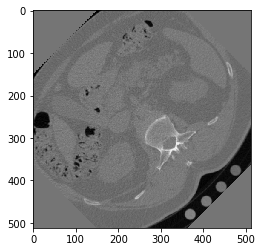

In [15]:
rotated_image = rotation3d(image, 45, 10, show=True)

# Canny edges (memory issue - not a problem)

In [ ]:
# https://simpleitk-prototype.readthedocs.io/en/latest/auto_examples/edges/plot_canny.html
# img2 = sitk.Cast(image, sitk.sitkInt16)
# canny_image = sitk.CannyEdgeDetection(img2)
canny_image = sitk.CannyEdgeDetection(sitk.Cast(image, sitk.sitkFloat32))

In [ ]:
z = 0
slice = sitk.GetArrayFromImage(canny_image)[z,:,:]
plt.imshow(slice, cmap='gray')
plt.title("Canny Image")

# Sharpen Image

Text(0.5, 1.0, 'Laplacial Image')

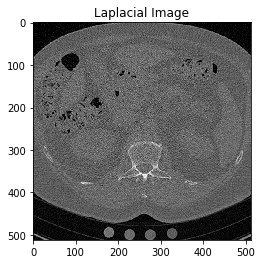

In [5]:
# Sharpen
laplacial_image = sitk.LaplacianSharpening(image)
z = 0
slice = sitk.GetArrayFromImage(laplacial_image)[z,:,:]
plt.imshow(slice, cmap='gray')
plt.title("Laplacial Image")

# Shrink Image

Text(0.5, 1.0, 'shrink image')

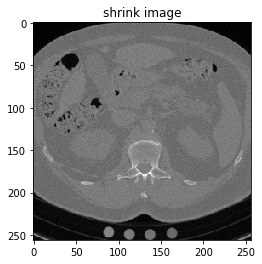

In [6]:
shrink_image = sitk.Shrink(image, [2,2,2])
z = 0
slice = sitk.GetArrayFromImage(shrink_image)[z,:,:]
plt.imshow(slice, cmap='gray')
plt.title("shrink image")

In [7]:
shrink_image.GetSize()

(256, 256, 323)

# Distance map

Text(0.5, 1.0, 'Distance Map')

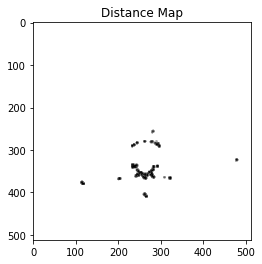

In [8]:
# https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1SignedMaurerDistanceMapImageFilter.html
# Distance map, 25 pixels to a feature between 700 and 750
distanceMap = sitk.SignedMaurerDistanceMap(sitk.BinaryThreshold(image, 700, 750))
Distance_map = sitk.IntensityWindowing (distanceMap, 0, 25, 0, 255)

z = 0
slice = sitk.GetArrayFromImage(Distance_map)[z,:,:]
plt.imshow(slice, cmap='gray')
plt.title("Distance Map")